In [26]:
import sys
import torch
import sys
import random
from pathlib import Path

import numpy as np
from matplotlib import cm

from skimage import io
from skimage.transform import resize
from torch.autograd import Variable

from PIL import Image as PILImage
from IPython.display import display, Image

In [11]:
mega_depth_path = '/home/harsimrat/workspace/MegaDepth'
model_path = '/data/pre-trained-models/best_generalization_net_G.pth'
sys.path.append(mega_depth_path)

In [13]:
input_h = 384
input_w = 512

In [5]:
from options.train_options import TrainOptions
from data.data_loader import CreateDataLoader
from models.models import create_model

In [12]:
model = create_model(model_path)

===========================================LOADING Hourglass NETWORK====================================================
model [HGModel] was created


In [28]:
def run_inference(model, image_path, width, height):
    
    total_loss =0
    toal_count = 0
    print("============================= TEST ============================")
    model.switch_to_eval()

    img = np.float32(io.imread(image_path))/255.0
    image_h, image_w = img.shape[:-1]

    img = resize(img, (height, width), order = 1)
    input_img =  torch.from_numpy( np.transpose(img, (2,0,1)) ).contiguous().float()
    input_img = input_img.unsqueeze(0)

    input_images = Variable(input_img.cpu())
    pred_log_depth = model.netG.forward(input_images)
    pred_log_depth = torch.squeeze(pred_log_depth)

    pred_depth = torch.exp(pred_log_depth)

    pred_inv_depth = 1/pred_depth
    pred_inv_depth = pred_inv_depth.data.cpu().numpy()

    depth = pred_inv_depth/np.amax(pred_inv_depth)

    depth /= depth.max()
    depth *= 255.0
    depth = depth.astype(np.uint8)
    
    depth = np.uint8(cm.jet(depth) * 255.0)

    print(depth.min(), depth.max(), depth.shape)
    pil_image = PILImage.fromarray(depth).convert('RGB')
    pil_image = pil_image.resize([image_w, image_h], PILImage.ANTIALIAS)

    display(pil_image)

In [42]:
images_path = '/nas/drives/phone_6plusT/keyframes/2019-08-09/video_09-29'

In [43]:
images = [i for i in Path(images_path).iterdir() if i.suffix == '.jpg']

/nas/drives/phone_6plusT/keyframes/2019-08-09/video_09-29/frame-002673.jpg


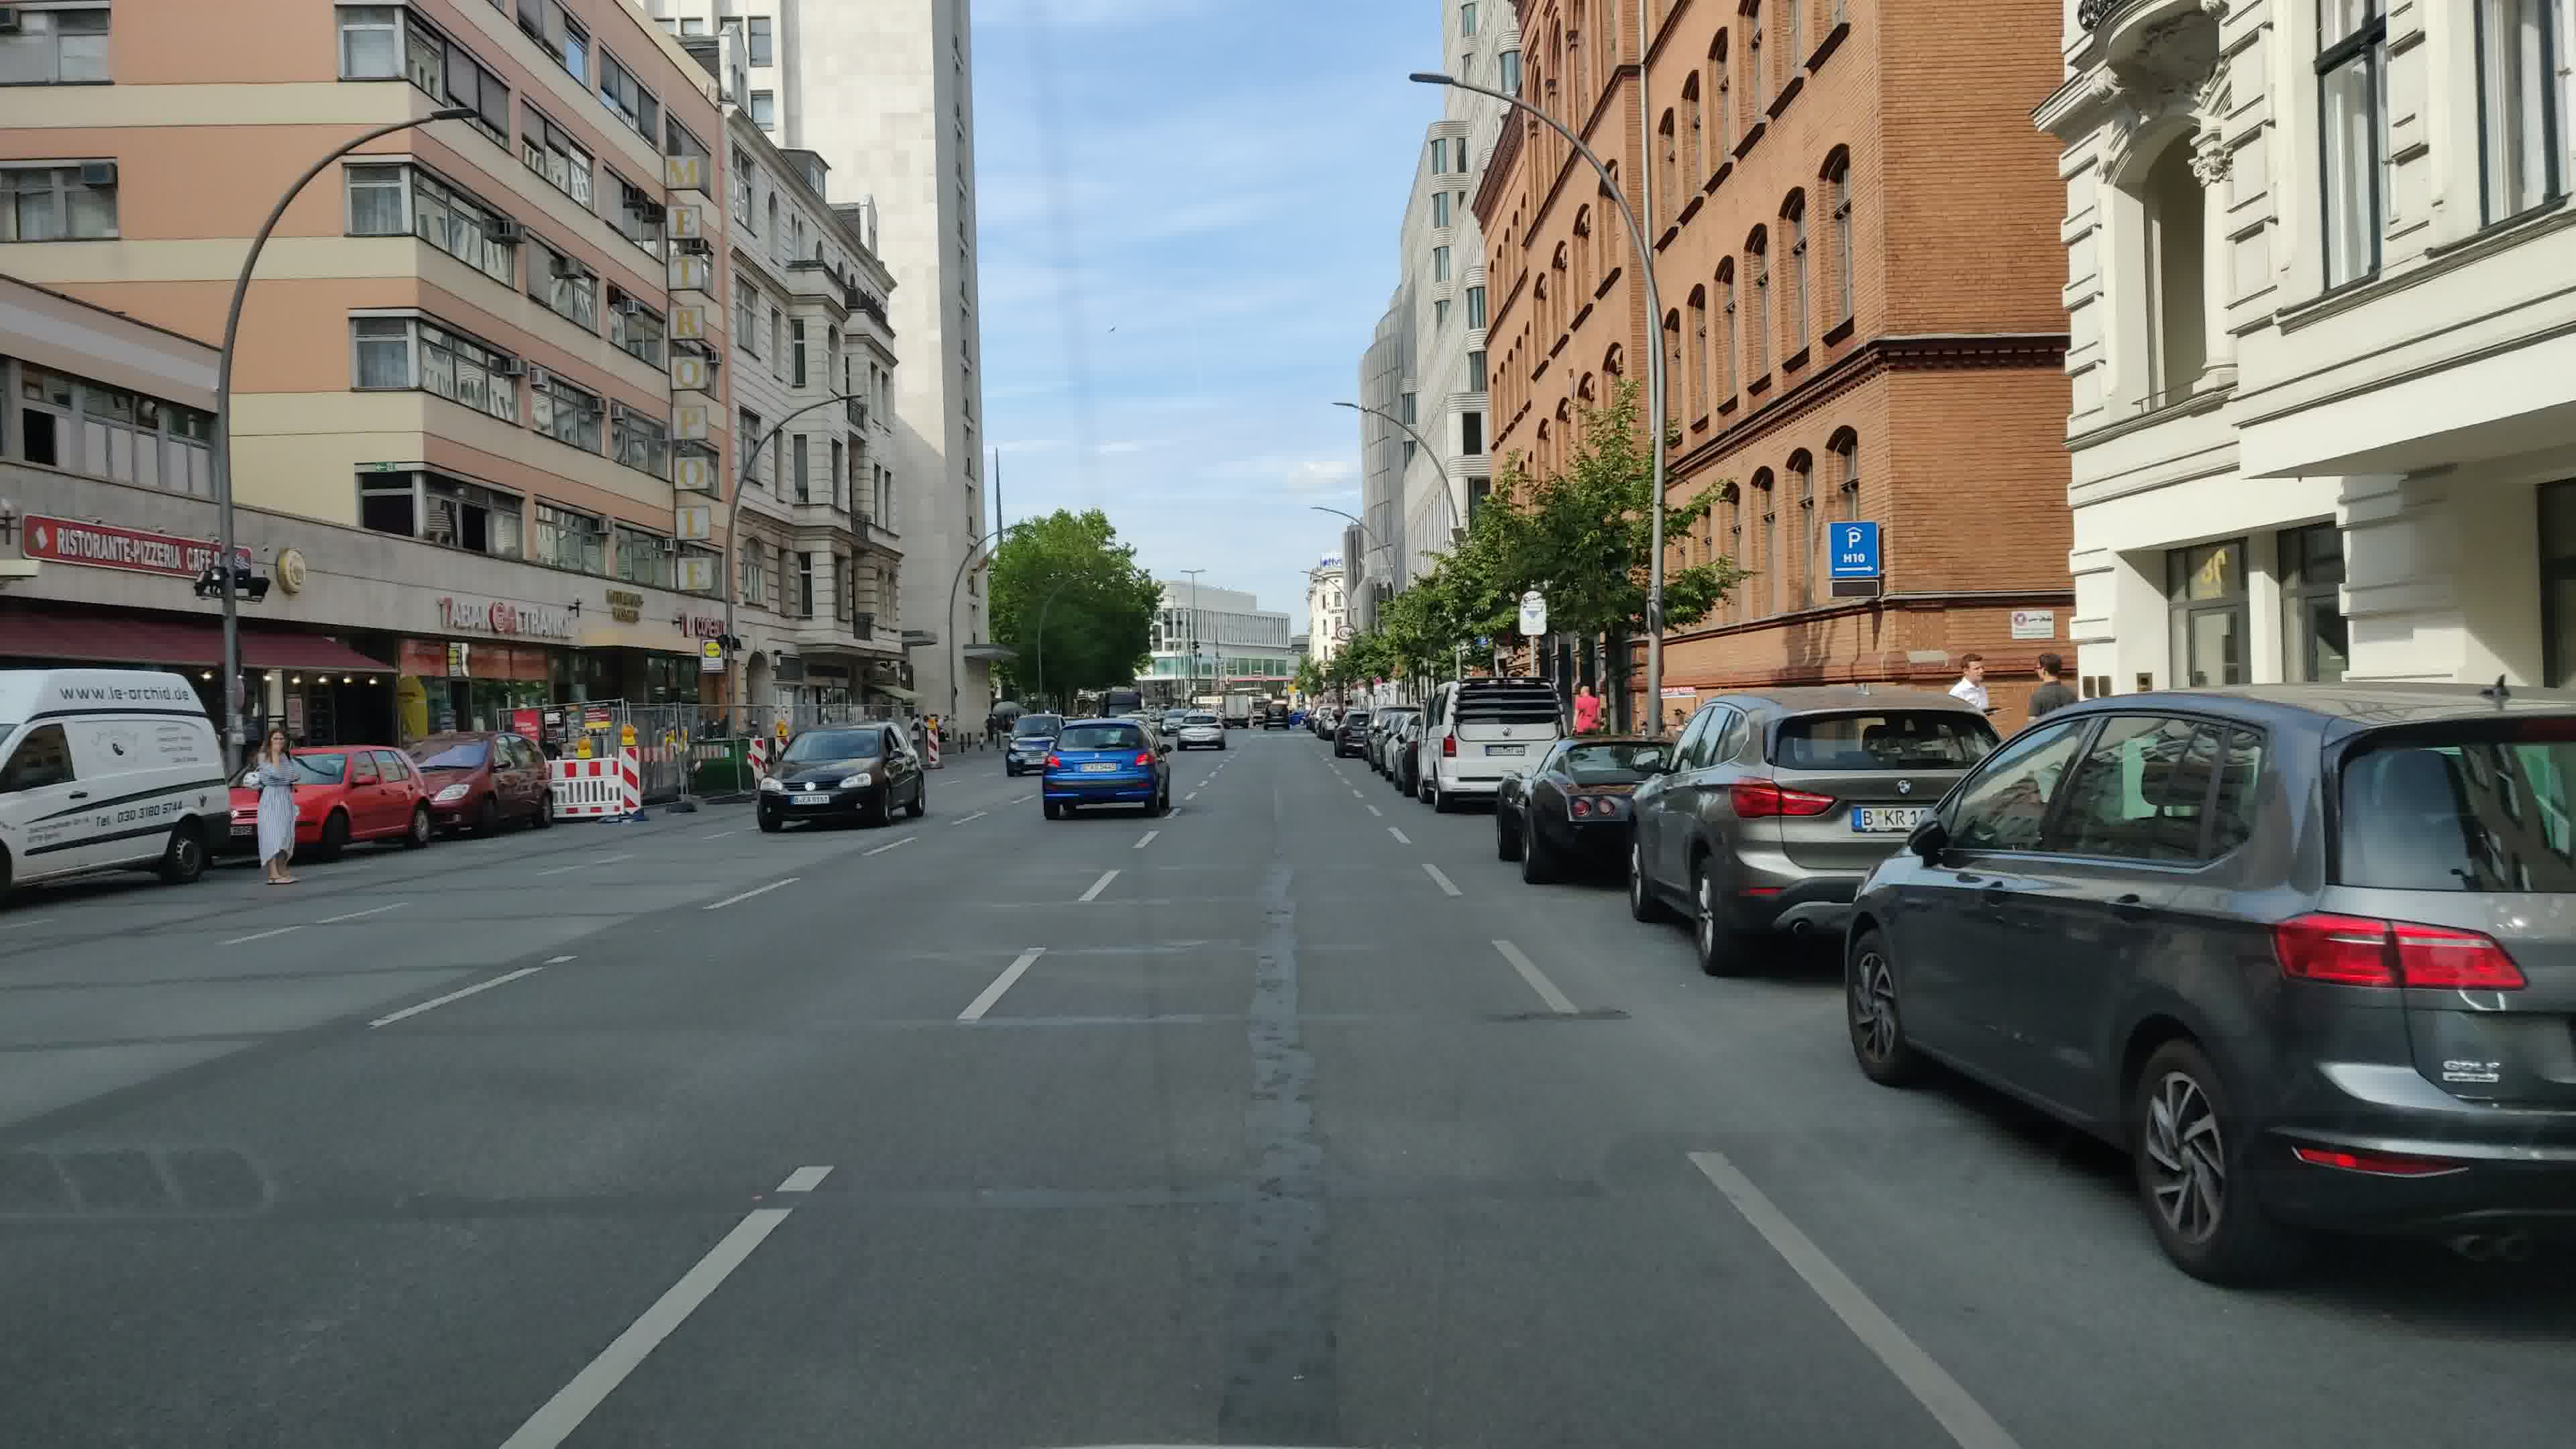

============================= TEST ============================
0 255 (384, 512, 4)


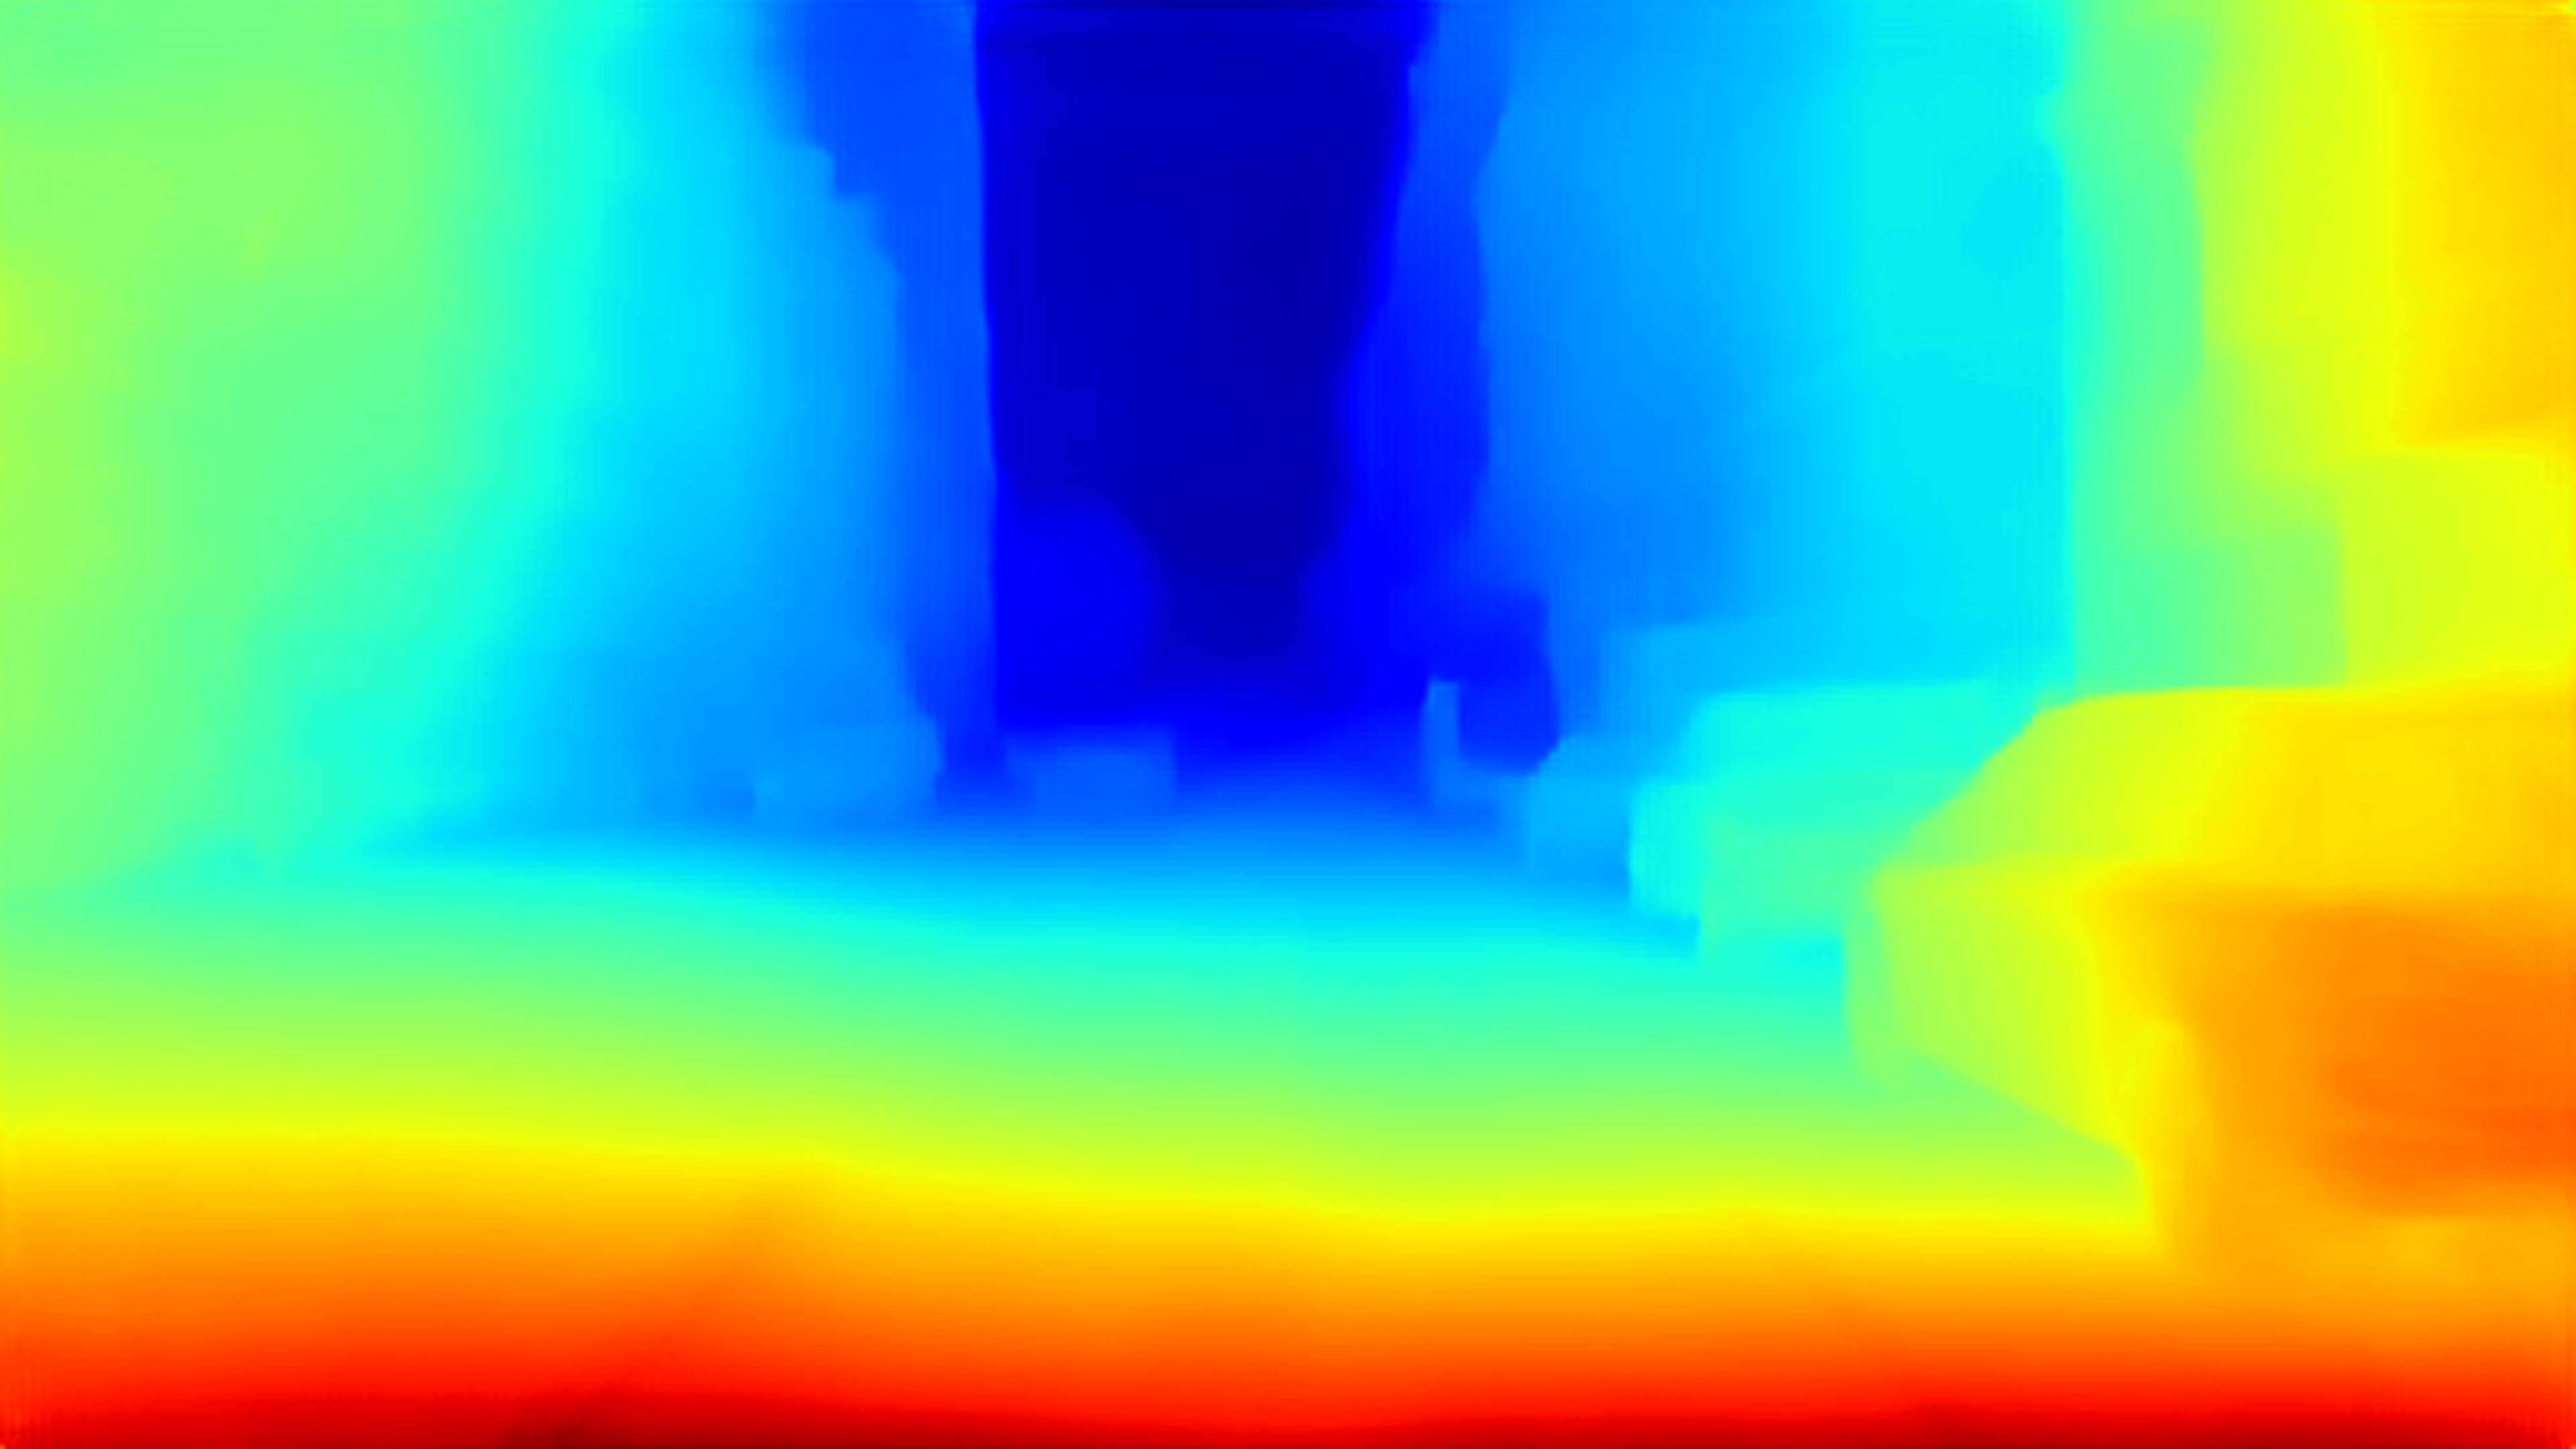

In [48]:
test_image = str(random.choice(images))
print(test_image)
display(Image(filename=test_image))
run_inference(model, test_image, height=input_h, width=input_w)